In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Aluno: Guilherme de Oliveira Mendes

Matrícula:180113496

## Objetivo

O objetivo com esse programa é criar um algoritmo que possa diferenciar imagens de uma gladius e um montante

## Início do processo

In [2]:
!pip install -Uqq fastai fastbook duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflo

In [3]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 724.7 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


Apos terminar de baixar e atualizar os requerimentos para criar o programa é necessário baixar 200 imagens de gladius e montante para que o programa possa usar como exemplo, e depois de baixado todas as imagens são redimensionadas  
(Será utilizado "Longsword" na pesquisa ao ínves de montante para que aumente as chances de pegar espadas ao ínves de placas de metal e "weapon" para evitar pegar imagens não relacionadas com as armas antigas)

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep
def search_images1(term, max_images=200):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')


searches = 'Gladius','Longsword'
path = Path('G_L')
if not path.exists():
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images1(f'{o} weapon'))
        sleep(10)
        resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Gladius weapon'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for 'Longsword weapon'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Depois de terminar de baixar as imagens é necessário verificar se ocorreu erro em baixar certas imagens e remover essas, para que isso não ocorra erros no programa

In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

15

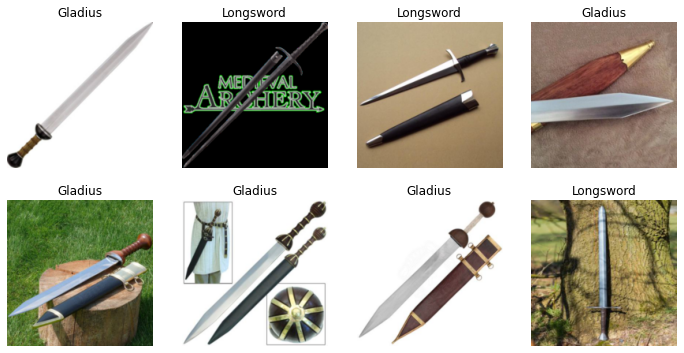

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=32),
    get_y=parent_label,
    item_tfms=[Resize(185, method='squish')]
).dataloaders(path)
dls.show_batch(max_n=8)

Após verificar as imagens é criado o Datablock do sistema, primeiro é especificado que a entrada é uma imagem e a saída é uma categoria(`ImageBlock`,`CategoryBlock`), após isso é utilizado uma função (`get_image_files`) para levar as imagens para o datablock para o sistema treinar.
depois disso é separado 20% das imagens para serem usadas para testar a precisão do sistema, depois disso é colocado os nomes das categorias nesse caso foi utilizado uma função(`get_image_files`) para que o nome seja o mesmo que o das pastas que nesse caso será Gladius e Longsword, a última linha muda o tamanho, 'esguichando' todas as imagens do datablock para 187x187 pixels já que todas as imagens precisam ser do mesmo tamanho para o datablock funcionar, depois disso é criado a classe dataloader que o pytorch itera para usar os dados do Datablock usando a GPU ou CPU, por fim pedimos para um exemplo dos grupos de dados que estão sendo passados pelo modelo mostrando a entrada e a saída do modelo

Após criado o datablock o modelo pode ser treinado, para isso é usado três parametros, os dados(`dls`), o modelo que é a função do modelo neural, nesse programa vai ser utilizado o modelo `resnet34` que usando a função `finetune()` é "treinado" para que possa ser utilizado da forma que é necessário para o programa

In [7]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(9)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.208798,0.753460,0.310811,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.546660,0.535007,0.202703,01:28
1,0.391403,0.389238,0.162162,01:10
2,0.276824,0.295111,0.121622,00:52
3,0.208772,0.243641,0.094595,00:53
4,0.167408,0.239105,0.067568,00:53
5,0.135329,0.232936,0.094595,00:53
6,0.112207,0.222018,0.094595,00:53
7,0.095010,0.225116,0.094595,00:53
8,0.081170,0.221765,0.094595,00:53


Depois de feito o fine tuning da rede neural, é utilizado a imagem de uma gladius para confirmar se o sistema está funcionando

In [9]:
def search_images(term, max_images=1):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [10]:
urls = search_images('Gladius', max_images=1)
urls[0]

Searching for 'Gladius'


'https://cdn.shopify.com/s/files/1/1721/5605/products/ICS-018_1024x.jpg?v=1551834437'

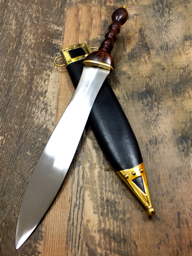

In [11]:
dest = 'gladius.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

In [12]:
is_a_gladius,_,probs = learn.predict(PILImage.create('gladius.jpg'))
print(f"This is a: {is_a_gladius}.")
print(f"Probability of being a Gladius: {probs[0]:.4f}")

This is a: Gladius.
Probability of being a Gladius: 1.0000


## Problemas com o código

O principal problema foi que o jupyter não funcionava no meu computador, o células de código não mandavam resposta nenhuma, sendo assím foi-se utilizado o Kaggle para se fazer esse projeto, outro problema foi para fazer o download das imagens que as vezes não funcionava, a célula rodava por menos de um segundo e parava,o problema foi resolvido após reiniciar a sessão no Kaggle 